### Evaluating the model on other rows

In [1]:
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file = open('df_extracted_basic', 'rb')
cv_df = pickle.load(file)

In [3]:
cv_df['CLNREVSTAT'].value_counts()

criteria_provided,_single_submitter                     231953
criteria_provided,_multiple_submitters,_no_conflicts     48754
no_assertion_criteria_provided                           36329
criteria_provided,_conflicting_interpretations           16434
no_assertion_provided                                    10274
reviewed_by_expert_panel                                  9062
no_interpretation_for_the_single_variant                   512
practice_guideline                                          23
Name: CLNREVSTAT, dtype: int64

In [4]:
# narrow rows down to just entries with single submissions
single_sub = ['no_assertion_criteria_provided','criteria_provided,_single_submitter']
cv_df = cv_df.loc[cv_df['CLNREVSTAT'].isin(single_sub)]

In [5]:
# drop rows with just drug_response as a CLNSIG
cv_df = cv_df.drop(cv_df[cv_df['CLNSIG'] == 'drug_response'].index)

#convert ['CLNSIG'] into just three catagories
cv_df.loc[cv_df['CLNSIG'].str.startswith("Benign") | cv_df['CLNSIG'].str.startswith("Likely_benign"), ['CLNSIG']] = 'Benign_cat'
cv_df.loc[cv_df['CLNSIG'].str.startswith("Uncertain_significance"), ['CLNSIG']] = 'Uncertain_significance_cat'
cv_df.loc[cv_df['CLNSIG'].str.startswith("Pathogenic") | cv_df['CLNSIG'].str.startswith("Likely_pathogenic"), ['CLNSIG']] = 'Pathogenic_cat'

three_act = ['Benign_cat','Uncertain_significance_cat','Pathogenic_cat']
cv_df = cv_df.loc[cv_df['CLNSIG'].isin(three_act)]

In [6]:
cv_df['CLNSIG'].value_counts()

Uncertain_significance_cat    132152
Benign_cat                     73065
Pathogenic_cat                 60360
Name: CLNSIG, dtype: int64

In [7]:
#drop columns not needed
cv_df = cv_df.drop(columns=['ALLELEID', 'CLNDISDB',
       'CLNHGVS', 'CLNREVSTAT', 'CLNVCSO', 'CLNVI',
       'GENEINFO', 'RS', 'CLNSIGCONF',
       'CLNDISDBINCL', 'CLNSIGINCL', 'SSR', 'DBVARID','Allele', 
       'IMPACT', 'SYMBOL', 'Gene','Feature_type','Feature','HGVSc','HGVSp','Existing_variation','DISTANCE',
       'STRAND','FLAGS','SYMBOL_SOURCE','HGNC_ID','TSL','APPRIS','REFSEQ_MATCH',
       'GIVEN_REF','USED_REF','MOTIF_NAME','MOTIF_POS','HIGH_INF_POS','MOTIF_SCORE_CHANGE','MPC'])

In [8]:
cv_df.head()

,CHROM,POS,ID,REF,ALT,AF_EXAC,CLNDN,CLNSIG,CLNVC,MC,...,Protein_position,Amino_acids,Codons,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1149118,96692,G,A,0.00004,Immunodeficiency_16,Pathogenic_cat,single_nucleotide_variant,SO:0001583|missense_variant,...,,,,,,,,22.6,3.147195,
1,1,1167674,60493,C,T,NaN,"Ehlers-Danlos_syndrome,_progeroid_type,_2",Pathogenic_cat,single_nucleotide_variant,SO:0001583|missense_variant,...,6,R/W,Cgg/Tgg,,deleterious_low_confidence,benign,,24.2,4.482313,-3
2,1,1167851,60488,A,G,NaN,Spondyloepimetaphyseal_dysplasia_with_joint_la...,Pathogenic_cat,single_nucleotide_variant,SO:0001583|missense_variant,...,65,S/G,Agc/Ggc,,deleterious,benign,,14.90,1.784550,
3,1,1167858,60489,C,T,NaN,Spondyloepimetaphyseal_dysplasia_with_joint_la...,Pathogenic_cat,single_nucleotide_variant,SO:0001583|missense_variant,...,67,P/L,cCc/cTc,,deleterious,probably_damaging,,24.9,4.885392,-3
4,1,1168124,60486,G,A,NaN,Spondyloepimetaphyseal_dysplasia_with_joint_la...,Pathogenic_cat,single_nucleotide_variant,SO:0001583|missense_variant,...,156,D/N,Gac/Aac,,deleterious,probably_damaging,,24.8,4.835293,1


## Below, copy code from 'third_model' to evaluate discrepancy between my model and the single_submitter values

In [9]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Extract columns to be pushed into model
prog_df = cv_df[['CLNSIG','AF_ESP','AF_EXAC','AF_TGP','CADD_RAW','BLOSUM62','LoFtool','PolyPhen','SIFT']]

# Clean and fill in missing values. BLOSUM62 missing values automatically mean 0. 
prog_df.loc[prog_df['BLOSUM62'] == '', ['BLOSUM62']] = '0'
prog_df.loc[prog_df['CADD_RAW'] == '', ['CADD_RAW']] = '0'
prog_df.loc[prog_df['AF_ESP'] == '', ['AF_ESP']] = '0'
prog_df.loc[prog_df['AF_EXAC'] == '', ['AF_EXAC']] = '0'
prog_df.loc[prog_df['AF_TGP'] == '', ['AF_TGP']] = '0'
prog_df.loc[prog_df['LoFtool'] == '', ['LoFtool']] = 'NaN'
prog_df.loc[prog_df['PolyPhen'] == '', ['PolyPhen']] = 'unknown'
prog_df.loc[prog_df['SIFT'] == '', ['SIFT']] = 'NaN'

prog_df['AF_ESP'].fillna(0, inplace=True)
prog_df['AF_EXAC'].fillna(0, inplace=True)
prog_df['AF_TGP'].fillna(0, inplace=True)

prog_df = prog_df.astype({
    'CADD_RAW': 'float', 
    'BLOSUM62': 'int64',
    'AF_ESP': 'float',
    'AF_EXAC': 'float',
    'AF_TGP': 'float',
    'LoFtool': 'float'})

In [10]:
prog_df['CLNSIG'].value_counts()

Uncertain_significance_cat    132152
Benign_cat                     73065
Pathogenic_cat                 60360
Name: CLNSIG, dtype: int64

In [11]:
X = prog_df[['AF_ESP','AF_EXAC','AF_TGP','CADD_RAW','BLOSUM62','LoFtool','PolyPhen','SIFT']]
y = prog_df['CLNSIG']

X = pd.get_dummies(X)

In [12]:
# Load pickled XGBoost model
with open("../models/xgboost.pickle", "rb") as pfile:
    exec("xgboost = pickle.load(pfile)")
xg_clas = eval('xgboost')

In [13]:
xg_clas.score(X,y)

0.6482489070966235

Text(33.0, 0.5, 'Annotated')

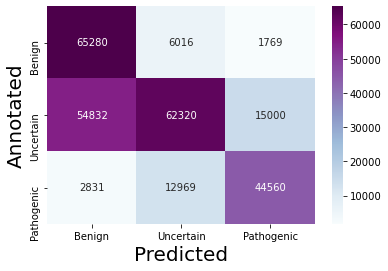

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = xg_clas.predict(X)
cf_matrix = confusion_matrix(y, y_pred)
#Swap rows 2,3 and columns 2,3, for better understanding
cf_matrix[[1,2]] = cf_matrix[[2,1]]
cf_matrix[:, [1, 2]] = cf_matrix[:, [2, 1]]

import seaborn as sns
columns = ['Benign','Uncertain','Pathogenic']
ax = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="BuPu", xticklabels = columns, yticklabels = columns)
plt.xlabel("Predicted", fontsize = 20)
plt.ylabel("Annotated", fontsize = 20)